<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium
!pip install scikit-learn-intelex
!pip install easyfsl
!pip install Pillow

!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
import pandas as pd, numpy as np
import os, itertools, shutil, requests, webbrowser, urllib.request, time

from selenium import webdriver
from bs4 import BeautifulSoup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

import PIL.Image
from IPython.core.display import Image

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/"

classes = "beaver, duck, bear, frog, sheep, rabbit, bird, lion, dolphin, wasp, badger, butterfly, codfish, cat, dog"
classesTr = ["beaver", "duck", "bear", "frog", "sheep", "rabbit", "cat"]
classesTe = ["bird", "lion", "dolphin", "wasp", "badger", "butterfly", "dog"]
classeForSimilarity = ["codfish"]

globalSize = 20
LEN_FOR_ONE_SCROLL = 20
image_size = 28
trainingNeeded = False

--- IMAGE RETRIEVAL ---

In [ ]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup


def getClassesImagesURLLIB():

  imagesNumber = 0

  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  for classe in classes.split(","):

    classeName = classe.replace(" ", "")
    os.makedirs(PATH_IMAGES+classeName)

    soup = getParser(classeName)
    img_tags = soup.find_all("img", class_="rg_i")
    for index in range(0, len(img_tags)):
      try:
          urllib.request.urlretrieve(img_tags[index]['src'], PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg")
          imagesNumber+=1
      except Exception as e:
          pass

  print(str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes.split(","))) + " per classes")

In [ ]:
getClassesImagesURLLIB()

300 images were downloaded. 20.0 per classes




--- PROTOTYPICAL NETWORK ---

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor,) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        #print("d(query, prototype) = ", dists)
        return scores


convolutional_network = resnet18(pretrained=False)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).cuda()

try:
  model.load_state_dict(torch.load(PATH_MODEL+"proto_model.pt"))
  print("model loaded from disk")
except:
  print("couldn't find a model in the specified folder. Do you have the right path ? [The model is in training configuration]")
  trainingNeeded = True

couldn't find a model in the specified folder. Do you have the right path ? [The model is in training configuration]


In [ ]:
class ZSLDataset(Dataset):
  
    def __init__(self, path, classesList, sizePerClass, transform=None):
      self.path = path
      self.classes = classesList
      self.innerSize = sizePerClass
      self.transform = transform

      self.samples = []
      self.get_labels = lambda : []
      for className in self.classes:
        images = os.listdir(self.path+className)
        for filename in images:
          self.samples.append((filename, self.classes.index(className)))

    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):

      info = self.samples[idx]
      filename, classIndex = info
      image = PIL.Image.open(self.path+self.classes[classIndex]+"/"+filename, mode="r")
      if self.transform:
        image = self.transform(image)
      return image, classIndex

In [ ]:
class DataManager:

  def __init__(self, data, N_WAY, N_SHOT, N_QUERY, N_EPISODES):
    self.data = data
    self.data.get_labels = lambda: [instance[1] for instance in data.samples]

    self.sampler = TaskSampler(self.data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EPISODES)
    self.loader = DataLoader(self.data, batch_sampler=self.sampler, num_workers=12, pin_memory=True, collate_fn=self.sampler.episodic_collate_fn,)

    (
    self.example_support_images,
    self.example_support_labels,
    self.example_query_images,
    self.example_query_labels,
    self.example_class_ids,
    ) = next(iter(self.loader))

In [ ]:
transformFunctionTrain = transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

transformFunctionTest = transforms.Compose(
        [
            # images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])

dataTr = ZSLDataset(PATH_IMAGES, classesTr, 20, transformFunctionTrain)
dataTe = ZSLDataset(PATH_IMAGES, classesTe, 20, transformFunctionTest)
dataTeval = ZSLDataset(PATH_IMAGES, classeForSimilarity, 20, transformFunctionTest)

In [ ]:
N_WAY_tr = 5  
N_SHOT_tr = 5
N_QUERY_tr = 10 

N_WAY_te = 1  
N_SHOT_te = 19 
N_QUERY_te = 1 

N_EVALUATION_TASKS = 100
N_TRAINING_EPISODES = 3000
N_VALIDATION_TASKS = 100

dataTrManager = DataManager(dataTr, N_WAY_tr, N_SHOT_tr, N_QUERY_tr, N_TRAINING_EPISODES)
dataTeManager = DataManager(dataTe, N_WAY_tr, N_SHOT_tr, N_QUERY_tr, N_EVALUATION_TASKS)
dataTevalManager = DataManager(dataTeval, N_WAY_te, N_SHOT_te, N_QUERY_te, 1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


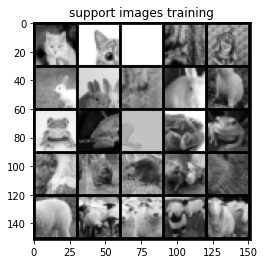

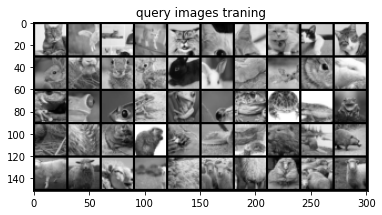

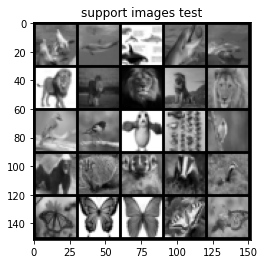

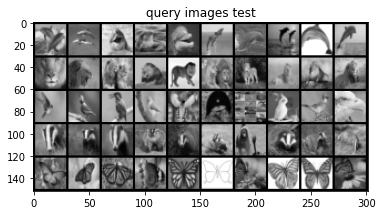

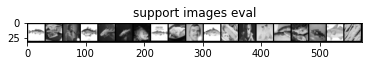

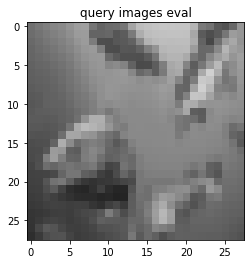

In [ ]:
plot_images(dataTrManager.example_support_images, "support images training", images_per_row=N_SHOT_tr)
plot_images(dataTrManager.example_query_images, "query images traning", images_per_row=N_QUERY_tr)

plot_images(dataTeManager.example_support_images, "support images test", images_per_row=N_SHOT_tr)
plot_images(dataTeManager.example_query_images, "query images test", images_per_row=N_QUERY_tr)

plot_images(dataTevalManager.example_support_images, "support images eval", images_per_row=N_SHOT_te)
plot_images(dataTevalManager.example_query_images, "query images eval", images_per_row=N_QUERY_te)

In [ ]:
# those two followings are the meta training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

if trainingNeeded:
  log_update_frequency = 10
  all_loss = []
  model.train()
  with tqdm(enumerate(dataTrManager.loader), total=len(dataTrManager.loader)) as tqdm_train:
      for episode_index, (
          support_images,
          support_labels,
          query_images,
          query_labels,
          _,
      ) in tqdm_train:
          loss_value = fit(support_images, support_labels, query_images, query_labels)
          all_loss.append(loss_value)

          if episode_index % log_update_frequency == 0:
              tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  torch.save(model.state_dict(), PATH_MODEL+"proto_model.pt")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 3000/3000 [12:20<00:00,  4.05it/s, loss=0.314]


In [ ]:
model.eval()

example_scores = model(
    dataTeManager.example_support_images.cuda(),
    dataTeManager.example_support_labels.cuda(),
    dataTeManager.example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)
data = dataTeManager.data

print("Ground Truth / Predicted")
for i in range(len(dataTeManager.example_query_labels)):
    print(
        f"{data.classes[dataTeManager.example_class_ids[dataTeManager.example_query_labels[i]]]} / {data.classes[dataTeManager.example_class_ids[example_predicted_labels[i]]]}"
    )

In [ ]:
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor,) -> [int, int]:
  
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    similarity = model(support_images.cuda(), support_labels.cuda(), query_images.cuda()).detach().data
    return (torch.max(similarity,1,)[1] == query_labels.cuda()).sum().item(), len(query_labels), similarity


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total, _ = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [ ]:
evaluate(dataTeManager.loader)

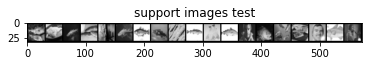

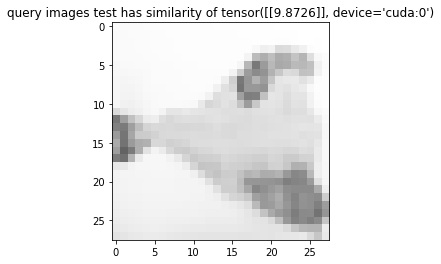

In [ ]:
_, _, similarity = evaluate_on_one_task(dataTevalManager.example_support_images, dataTevalManager.example_support_labels, dataTevalManager.example_query_images, dataTevalManager.example_query_labels)

plot_images(dataTevalManager.example_support_images, "support images test", images_per_row=N_SHOT_te)
plot_images(dataTevalManager.example_query_images, "query images test has similarity of "+str(-similarity), images_per_row=N_QUERY_te)